In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys
sys.path.insert(0, '/Users/kedzie/Documents/Berkeley/notebooks/utilities')

import pdb
import pandas as pd
import numpy as np
# import bokeh
# import scipy
# from scipy.optimize import curve_fit
from matplotlib import rcParams as rc
rc['mathtext.default'] = 'regular'
import matplotlib.pyplot as plt
from collections.abc import Iterable


from utility_functions.utils import *

In [2]:
def baselinecorr(data, mz, baseline_start, baseline_end):
    #data is the DEMS mass spec dataframe, mz is the mass spec number you're interested in, ...
    # baseline_start is the end of initial ocv (in min), baseline_end is the start of baseline ocv after cycling (min)
    #find where the ocv ends by comparing eclab times with labview times
    
    index = getnearpos(data['time/min'], baseline_start)-1
    index2 = getnearpos(data['time/min'], baseline_end)+20
    
    plt.figure()
    plt.plot(data['time/min'], data[str(mz)], '--', label=str(mz))
    
    #convert mass data into dataframe variables
    d = {'time/min' : data['time/min'][:index], str(mz) : data[str(mz)][:index], }
    d2 =  {'time/min' : data['time/min'][index2:], str(mz): data[str(mz)][index2:] }

    df = pd.DataFrame(d); df2 = pd.DataFrame(d2)
    newdf = pd.DataFrame()
    newdf = pd.concat([df,df2])
    row,col= data.shape
    
    def slope(fullfile, mz, time1, time2):
        m=(fullfile[str(mz)].iloc[time2+3]-fullfile[str(mz)].iloc[time1])/(fullfile['time/min'].iloc[time2+3]-fullfile['time/min'].iloc[time1])
        return m
    
    def lin(fullfile,time,maz,cpstart,cpend):
        m= (maz.iloc[cpend]-maz.iloc[cpstart]) / (time.iloc[cpend]-time.iloc[cpstart])
        line=(m*(time-time.iloc[cpstart]) + maz.iloc[cpstart])
        return m #fullfile
    
    if mz == 2:
        m= slope( data, mz, index, index2)
        correct=(m)*(data['time/min']- data['time/min'].iloc[index]) + data[str(mz)].iloc[index]

        
    elif mz == 32:
        m= slope( data, mz, index, index2+10 )
        correct = (m)*(data['time/min']- data['time/min'].iloc[index]) + data[str(mz)].iloc[index]
        
        #correct = -4.0880*10**-6*data['time/min'] + 1.0521*10**-1
    elif mz == 44:
        m= slope( data, mz, index, index2)
        correct = (m)*(data['time/min']- data['time/min'].iloc[index]) + data[str(mz)].iloc[index]
        

    plt.plot(data['time/min'], correct, '.')
    data[str(mz)] = data[str(mz)]-correct
    #plt.xlim(0,200)
    
    plt.plot(data['time/min'], data[str(mz)], '-.', label='correction')
    plt.legend()                            
    
    return (data)


In [3]:

#---------------------- DEMS DATA ANALYSIS ---------------------
def read_dems(file):
    df = pd.read_csv(file, sep ='\t')
    df = df.rename(columns=lambda x: x.replace('.00000', ''))
    df.rename(columns={'0':'time/min', '0.1':'temperature/C', '0.2': 'pressure/torr', '0.3':'current/mA', '0.4':'voltage/V'}, inplace= True)
    #normalize time function
    df['time/min'] = df['time/min']-df['time/min'].iloc[0]
    
    return df

def find_charge(fold):
    import os
    files = os.listdir(fold)
    import re 
    regex = 'chrg'
    look='mpt'
    #find the file names that have 'chrg' in the name and then find only the ones of those that are .mpt files
    all_chrg= [fold + f for f in files if re.search(regex, f)]
    chrg_ec = [ i for i in all_chrg if re.search(look, i)]
    chrg_ec.sort()

    #read in the mpts as dataframes and put in list ls
    ls=[]
    for i in range(len(chrg_ec)):
        ls.append(read_data(chrg_ec[i]))
        
    #normalize all the dataframes by time zero in first dataframe
    for i in range(len(ls)):
        ls[i]['time/s']= ls[i]['time/s']-ls[0]['time/s'].iloc[0]
    
    return(ls)

def convert_ion_current(demsdata):
    #slopes and intercepts in an array [oxygen, co2, hydrogen, ethylene, carbon monoxide]
    #most recent:
    m = [1.144462577, 1.041140556, 0.06148247455, 1.690955209, 0.7959230955]
    #m = [1.463047028, 1.255655142, 0.06148247455*1.2, 1.690955209, 0.7959230955]
    #m = [1.1513186, 1.01161546, 0.06148247455, 1.690955209, 0.7959230955]
    
    #may 2021 calibration
    m = [1.4486, 0.94558, 0.06148247455, 1.690955209, 0.7959230955]
    
    #inf_ar = 278.6590323 * demsdata['36']
    inf_ar = 288.7462016 * demsdata['36']   #as of 2/2019
    
    names= ['2','26','28','32','34','36','44','45']
    vol = 499 #uL *10^-6 
    R = 62.363577 #  L*torr / (K*mol)
    
    #covert all pressures into umoles
    demsdata['2'] = (m[2] * demsdata['2']/inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)    
    demsdata['26'] = (m[3] * demsdata['26'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)
    demsdata['28'] = (m[4] * demsdata['28'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)    
    demsdata['32'] = (m[0] * demsdata['32'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)
    demsdata['34'] = (m[0] * demsdata['34'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)
    #demsdata['36'] = (m[0] * demsdata['36'] *10**-9/inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)
    demsdata['44'] = (m[1] * demsdata['44'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)
    demsdata['45'] = (m[1] * demsdata['45'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)
    
#     for i in range(len(names)):
#         demsdata[names[i]] = demsdata[names[i]] * vol / R / ( demsdata['temperature/C'] + 273 )

    return (demsdata) 


charge current (mA): 0.5001706547083333
o2: 6.378510468231961 h2: 19.136605598042706 -3.250250001072821
umoles O2: 6.378510468231961
e per mol: 5.85156499220489
charge current (mA): 0.050167391347873506
o2: 0.001964320128629869 h2: 0.6957675104216259 -0.48573739442894215
umoles O2: 0.001964320128629869
e per mol: 9528.92353180446


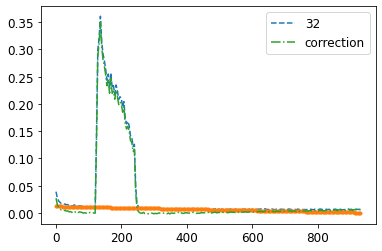

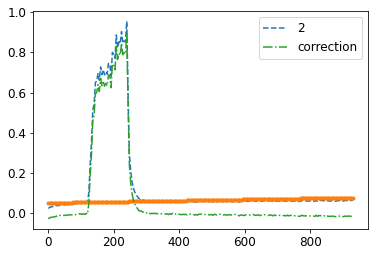

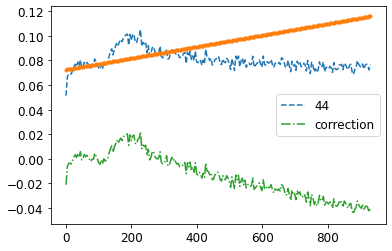

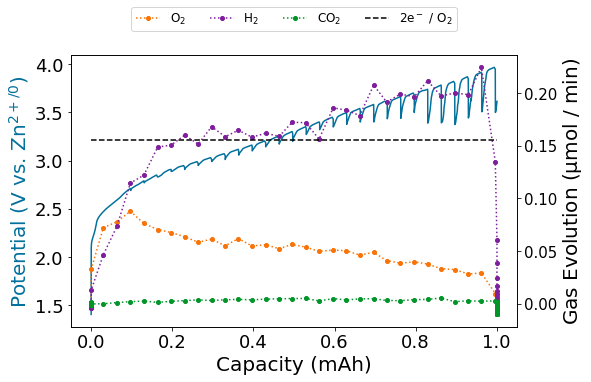

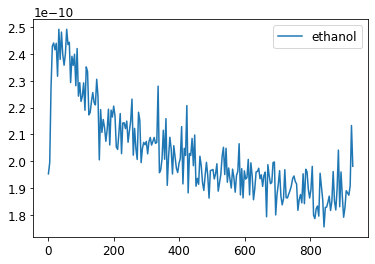

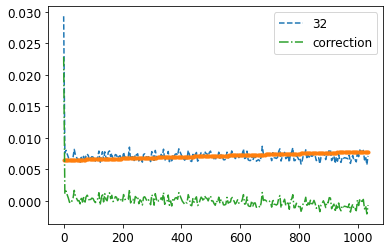

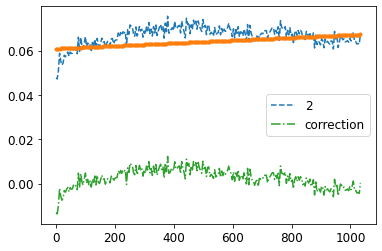

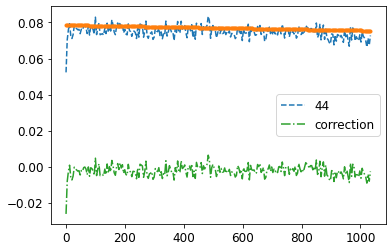

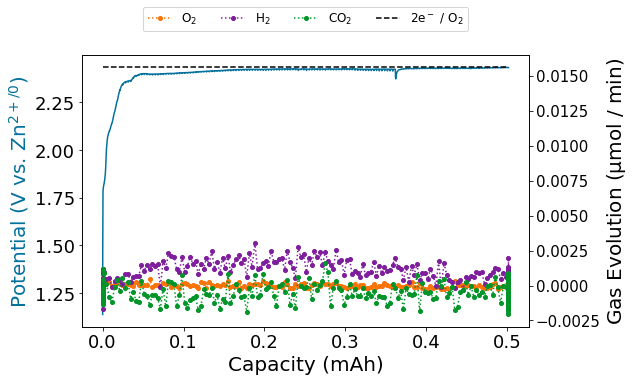

In [50]:
#plot galvanostatic charge
def plot_dems(chrg_ec, demi, r, ethylene='None', n=2 ):
    end_ocv= chrg_ec[1]['time/s'].iloc[-1]/60
    umolesdf = convert_ion_current(demi) 
    print('charge current (mA): '+ str(np.mean(chrg_ec[1]['I/mA'])))
    oxy = baselinecorr( demi, 32, chrg_ec[0]['time/s'].iloc[-1]/60, end_ocv)
    hydro = baselinecorr( oxy, 2, chrg_ec[0]['time/s'].iloc[-1]/60, end_ocv)
    co2 = baselinecorr( hydro, 44, chrg_ec[0]['time/s'].iloc[-1]/60, end_ocv)
    #c2h4 = baselinecorr( co2, 26, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
    #co = baselinecorr( c2h4, 28, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
    umolesdf=co2
    
    #convert ion current to moles of gas for baseline corrected data
    timediff= np.mean(np.gradient(umolesdf['time/min']))
    charge_i= np.mean(chrg_ec[1]['I/mA'])
    
    charge_start= chrg_ec[1]['time/s'].iloc[0]/60 #find the start time for charge in eclab
    
    cap=[]
    curr=[]
    
    new= chrg_ec[1]
        
    for j in range(len(umolesdf)):  
        index=getnearpos( chrg_ec[1]['time/s'], (umolesdf['time/min'].iloc[j]*60))
        #index=np.argmin(np.abs(new['time/s']-umolesdf['time/min'].iloc[j]*60).values)
        cap.append( new['Capacity/mA.h'].iloc[index])
        curr.append( new['I/mA'].iloc[index])

    umolesdf['Capacity/mAh']= cap
    umolesdf['I/mA']=curr
    
    x= [0.0, chrg_ec[1]['Capacity/mA.h'].iloc[-1]]
    y= [3.6*charge_i/60/(n*96485)*10**6, 3.6*charge_i/(n*96485*60)*10**6]
    
    fig,ax = plt.subplots(figsize= (8,5), facecolor='None')
    ax2=ax.twinx()
    start_charge= getnearpos(umolesdf['time/min'], chrg_ec[0]['time/s'].iloc[-1]/60)
    end_charge=getnearpos(umolesdf['time/min'], chrg_ec[1]['time/s'].iloc[-1]/60)+3
    umoles_32 = np.cumsum(umolesdf['32']).iloc[end_charge+5] - np.cumsum(umolesdf['32']).iloc[start_charge]
    umoles_2 = np.cumsum(umolesdf['2']).iloc[-1] - np.cumsum(umolesdf['2']).iloc[start_charge]
    umoles_44 = np.cumsum(umolesdf['44']).iloc[-1] - np.cumsum(umolesdf['44']).iloc[start_charge]

    print ('o2: '+ str(umoles_32), 'h2: ' + str(umoles_2), umoles_44)
    factor= umoles_32/34
    factor=1
    
    if n==2:
        factor=1
    j1= 5
    j2=50
    #ax2.plot(umolesdf['Capacity/mAh'][2:] , 3.6*umolesdf['I/mA'][2:]/(n*96485*60)*10**6 , 'ko:', markersize=4, label= str(n)+ 'e$^-$ / O$_2$')
    ax2.plot(umolesdf['Capacity/mAh'][5:-22], (umolesdf['32']/timediff/factor)[6:-21] , 'o:', markersize=4, label='O$_2$', color='xkcd:orange')   
    ax2.plot(umolesdf['Capacity/mAh'][5:-22], (umolesdf['2']/timediff/factor)[6:-21] , 'o:', markersize=4, label= 'H$_2$', color='xkcd:purple')
    #ax2.plot(umolesdf['Capacity/mAh'][:100], (umolesdf['28']/timediff/factor)[:100] , 'o:', alpha=0 , markersize=4, label = '28')
    ax2.plot(umolesdf['Capacity/mAh'][5:-22], (umolesdf['44']/timediff/factor)[6:-21] , 'o:', markersize=4, label = 'CO$_2$', color = 'xkcd:irish green')
    #ax2.plot(umolesdf['Capacity/mAh'][:60], (umolesdf['36']/timediff/factor)[:60] , 'o:', markersize=4, label = '36')
    
    if ethylene !='None':
        ax2.plot((umolesdf['Capacity/mAh'][18:90]), (umolesdf['28']/timediff)[18:90] , 'o:', markersize=4, label = 'C$_2$H$_4$')
    
    ax2.plot(x,y, 'k--', label= str(n)+ 'e$^-$ / O$_2$')
    
    ax2.legend(loc='upper center', bbox_to_anchor=[0.5, 1.2], ncol=4) #, title= 'm/z value')
    
    ax.plot(chrg_ec[1]['Capacity/mA.h'], chrg_ec[1]['Ewe/V'],'xkcd:ocean blue')
    
   # ax.set_ylim([1.6,3.0])
    #ax2.set_ylim([-0.001,0.01])
    rc['font.size'] = 12
#     for i in range (1,len(chrg_ec)):
#         ax2.plot(chrg_ec[i]['Capacity/mA.h'], chrg_ec[i]['Ewe/V'],'m')
    ax.set_xlabel('Capacity (mAh)', fontsize=20)
    ax.set_ylabel('Potential (V vs. Zn$^{2+ / 0}$)', color='xkcd:ocean blue', fontsize=20)
    ax2.set_ylabel('Gas Evolution ($\mu$mol / min)', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax2.tick_params(axis='y', which='major', labelsize=15)


    #plt.xticks(np.arange(0, 1.05, step=0.1))
    epermol= chrg_ec[1]['Capacity/mA.h'].iloc[-1]*3.6/96485/(umoles_32/factor)*10**(6)


    #     if n==1:
#         epermol= chrg_ec[3]['Capacity/mA.h'].iloc[-1]*3.6/96485/(umoles_32/factor)*10**(6)
#     else:
#         epermol= chrg_ec[2]['Capacity/mA.h'].iloc[-1]*3.6/96485/(umoles_32/factor)*10**(6)

    #theor_o2 = disch_ec[1]['Capacity/mA.h'].iloc[-1]*3.6/96485
    
    print('umoles O2: '+ str(umoles_32))   
    print('e per mol: ' + str(epermol))
    
    return

#plt.savefig('/Users/kedzie/Desktop/qual figures/180928_CP cycle 2 dems.png', transparent = True, dpi=600, bbox_inches='tight')

mgno3char = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210217_Mg(NO3)2_500uA_charge_dems/210217_Mg(NO3)2_500uA_charge_dems_2021-02-17_17.38_47.txt')
mgno3_fol = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210217_Mg(NO3)2_500uA_charge_dems/')
plot_dems(mgno3_fol, mgno3char, 1, n=2)




#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210217_Mg(NO3)2_500uA_charge_dems/210217_Mg(NO3)2_500uA_dems.png', transparent = True, dpi=600, bbox_inches='tight')


plt.figure()
plt.plot(mgno3char['time/min'], mgno3char['46'], label='ethanol')
#plt.plot(mgno3char['time/min'], mgno3char['28'], label='ethene')

plt.legend()

arcontrol = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210218_Mg(NO3)2_chargeunderAr_dems/210218_Mg(NO3)2_chargeunderAr_dems_control_2021-02-18_15.47_02.txt')
arcontrol_fol = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210218_Mg(NO3)2_chargeunderAr_dems/')
plot_dems(arcontrol_fol, arcontrol, 1, n=2)



charge current (mA): 0.10019145671954674
o2: 0.7568928891018161 h2: 1.6101141044703697 0.29178228396965444
umoles O2: 0.7568928891018161
e per mol: 8.196373683159322


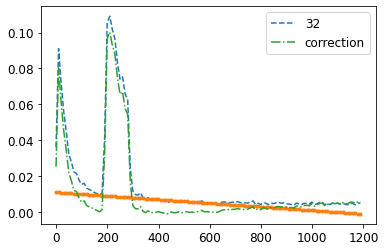

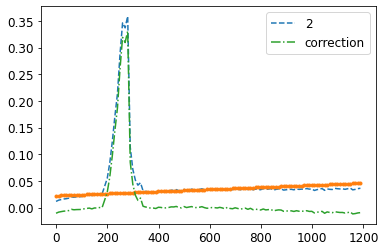

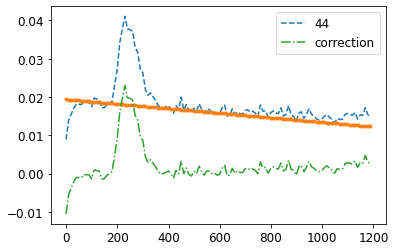

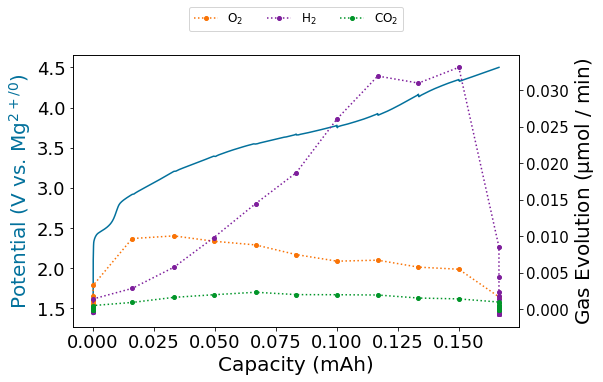

In [150]:
dme_no3_dems = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210311_MgO2_cycle100uA_nonaqueousDME_dems/210312_Mg(NO3)2_DME_nonaqueous_charge_100uA_dems_2021-03-12_12.47_47.txt')
dme_no3_fold = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210311_MgO2_cycle100uA_nonaqueousDME_dems/')

plot_dems(dme_no3_fold[3:5], dme_no3_dems, 1, n=2)




No handles with labels found to put in legend.
No handles with labels found to put in legend.


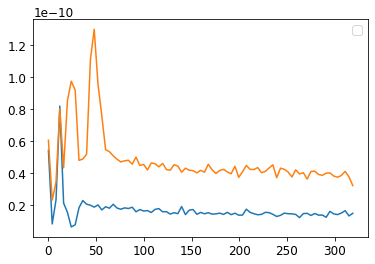

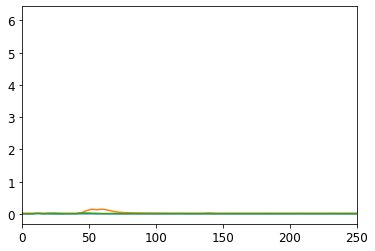

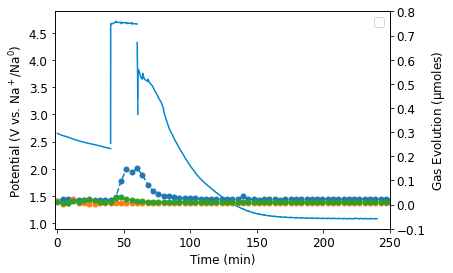

In [29]:
voltagelimit=read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2019/190803_Na_MCMB_voltagelimit_dems/190803_Na_MCMB_voltagelimit_dems_p_2019-08-03_12.07_09.txt')
potentials= folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2019/190803_Na_MCMB_voltagelimit_dems/')

plt.figure()
plt.plot(voltagelimit['time/min'], voltagelimit['32'])
#plt.plot(voltagelimit['time/min'], voltagelimit['2'])
plt.plot(voltagelimit['time/min'], voltagelimit['44'])
plt.legend()

umolesdf = convert_ion_current(voltagelimit) 
plt.figure()
plt.plot(umolesdf['time/min'], umolesdf['32'])
plt.plot(umolesdf['time/min'], umolesdf['2'])
plt.plot(umolesdf['time/min'], umolesdf['44'])
plt.xlim(0,250)
end_ocv= potentials[3]['time/s'].iloc[-1]/60
    
# oxy = baselinecorr( umolesdf, 32, potentials[0]['time/s'].iloc[-1], end_ocv)
# hydro = baselinecorr( oxy, 2, potentials[0]['time/s'].iloc[-1], end_ocv)
# co2 = baselinecorr( hydro, 44, potentials[0]['time/s'].iloc[-1], end_ocv)
# umolesdf=co2
    
    #convert ion current to moles of gas for baseline corrected data
timediff= np.mean(np.gradient(umolesdf['time/min']))

fig, ax= plt.subplots() 
ax2=ax.twinx()
plt.xlim(-2,250)
ax2.plot(umolesdf['time/min'],umolesdf['2'] ,'o--', markersize=5)
ax2.plot(umolesdf['time/min'],umolesdf['32'] ,'o--', markersize=5)
ax2.plot(umolesdf['time/min'],umolesdf['44'] ,'o--', markersize=5)
ax.plot(potentials[0]['time/s']/60, potentials[0]['Ewe/V'], 'xkcd:cerulean' )
ax.plot(potentials[1]['time/s']/60, potentials[1]['Ewe/V'], 'xkcd:cerulean' )
ax.plot(potentials[2]['time/s']/60, potentials[2]['Ewe/V'], 'xkcd:cerulean' )
ax.plot(potentials[3]['time/s']/60, potentials[3]['Ewe/V'], 'xkcd:cerulean' )
plt.ylim(-0.1,0.8)

ax2.legend()
ax.set_xlabel("Time (min)")
ax.set_ylabel("Potential (V vs. Na$^+$/Na$^0$)")
ax2.set_ylabel('Gas Evolution ($\mu$moles)')

#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2019/190803_Na_MCMB_voltagelimit_dems/voltage limit mcmb dems.png', transparent = True, dpi=600, bbox_inches='tight')




cp_mcmb= folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2019/190804_Na_MCMB_CP_dems/')
cp_dems= read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2019/190804_Na_MCMB_CP_dems/190804_Na_MCMB_CP_dems_chrg_2019-08-04_19.47_26.txt')

#plot_dems(cp_mcmb, cp_dems, r=1, n=1)
#plt.savefig('/Users/kedzie/Desktop/MCMB graphite CP dems.png', transparent = True, dpi=600, bbox_inches='tight')



In [11]:
#plot chronoamperometric charge on DEMS
def plot_dems2(chrg_ec, demi, r, ethylene='None', n=1 , percent='None'):
    #oxyi= baselinecorr( demi, 36, chrg_ec[0]['time/s'].iloc[-1], time_min)
    end_ocv= chrg_ec[3]['time/s'].iloc[-1]/60
    umolesdf = convert_ion_current(demi) 
    
    #umolesdf.to_csv('/Users/kedzie/Desktop/190413_na_graphite_MCMB_CA_dems_convertedcurrent.csv')
    
    oxy = baselinecorr( demi, 32, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
    hydro = baselinecorr( oxy, 2, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
    co2 = baselinecorr( hydro, 44, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
    #c2h4 = baselinecorr( co2, 26, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
    #co = baselinecorr( c2h4, 28, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
    
    #pdb.set_trace()
    #convert ion current to moles of gas for baseline corrected data
    umolesdf = co2
    total_umoles= umolesdf['2']+umolesdf['32']+umolesdf['44']
    timediff= np.mean(np.gradient(umolesdf['time/min']))

    
    chrg_ec[2]['Capacity/mA.h'] += chrg_ec[1]['Capacity/mA.h'].iloc[-1]
    if n==1:
        chrg_ec[3]['Capacity/mA.h'] += chrg_ec[2]['Capacity/mA.h'].iloc[-1]
    print(chrg_ec[3]['Capacity/mA.h'].iloc[-1])    
    charge_i= np.mean(chrg_ec[1]['I/mA'])  #normalize charge current by surface area (mA/cm2)
    charge_start= chrg_ec[1]['time/s'].iloc[0]/60 #find the start time for charge in eclab
    cap=[]
    curr=[]
    if n==1:
        new=pd.concat([chrg_ec[1], chrg_ec[2], chrg_ec[3]], sort=True)
    else:
        new=pd.concat([chrg_ec[1], chrg_ec[2]], sort=True)
        
    for j in range( len(umolesdf)):  
        
        index=getnearpos( new['time/s'], (umolesdf['time/min'].iloc[j]*60))
        #index=np.argmin(np.abs(new['time/s']-umolesdf['time/min'].iloc[j]*60).values)
        
        cap.append( new['Capacity/mA.h'].iloc[index])
        curr.append( new['I/mA'].iloc[index])
        #print( str(new['time/s'].iloc[index]/60) + ' and '+ str(umolesdf['time/min'].iloc[j]) )

    umolesdf['Capacity/mAh']= cap
    umolesdf['I/mA']=curr
    
    
    x= [0.0, chrg_ec[2]['Capacity/mA.h'].iloc[-1]]
    y= [3.6*charge_i/60/(n*96485)*10**6, 3.6*charge_i/(n*96485*60)*10**6]
    
    fig,ax = plt.subplots(figsize= (8,5), facecolor='None')
    ax2=ax.twinx()
    start_charge= getnearpos(umolesdf['time/min'], chrg_ec[0]['time/s'].iloc[-1]/60)
    end_charge=getnearpos(umolesdf['time/min'], chrg_ec[3]['time/s'].iloc[-1]/60)+3
    umoles_32 = np.cumsum(umolesdf['32']).iloc[end_charge] - np.cumsum(umolesdf['32']).iloc[start_charge]
    umoles_2 = np.cumsum(umolesdf['2']).iloc[end_charge] - np.cumsum(umolesdf['2']).iloc[start_charge]
    umoles_44 = np.cumsum(umolesdf['44']).iloc[-1] - np.cumsum(umolesdf['44']).iloc[5]
    print (umoles_32, umoles_2, umoles_44)
    factor=1
    #ax2.plot(umolesdf['Capacity/mAh'][6:80] , 3.6*umolesdf['I/mA'][6:80]/(n*96485*60)*10**6 , 'ko:', markersize=4, label= str(n)+ 'e$^-$ / O$_2$')
#     ax2.plot(umolesdf['Capacity/mAh'][4:90], (umolesdf['32']/timediff/factor)[5:91] , 'o:', markersize=4, label='O$_2$', color='xkcd:orange')
#     ax2.plot(umolesdf['Capacity/mAh'][4:110], (umolesdf['2']/timediff)[4:110] , 'o:', markersize=4, label= 'H$_2$', color='xkcd:purple')
#     ax2.plot(umolesdf['Capacity/mAh'][4:110], (umolesdf['44']/timediff)[4:110] , 'o:', markersize=4, label = 'CO$_2$', color='xkcd:irish green')
    
    if percent=='on':
        ax2.plot(umolesdf['Capacity/mAh'][6:90] , (umolesdf['32']/total_umoles*100)[7:91] , 'o:', markersize=4, label='O$_2$', color='xkcd:tangerine')
        ax2.plot(umolesdf['Capacity/mAh'][6:90], (umolesdf['2']/total_umoles*100)[7:91] , 'o:', markersize=4, label= 'H$_2$', color='xkcd:burnt orange')
        ax2.plot(umolesdf['Capacity/mAh'][6:90], (umolesdf['44']/total_umoles*100)[7:91] , 'o:', markersize=4, label= 'CO$_2$', color='xkcd:maroon', alpha=0.9)
    else:
        ax2.plot(umolesdf['Capacity/mAh'][6:80] , 3.6*umolesdf['I/mA'][6:80]/(n*96485*60)*10**6 , 'ko:', markersize=4, label= str(n)+ 'e$^-$ / O$_2$')
        ax2.plot(umolesdf['Capacity/mAh'][4:90], (umolesdf['32']/timediff/factor)[4:90] , 'o:', markersize=4, label='O$_2$', color='xkcd:orange')
        ax2.plot(umolesdf['Capacity/mAh'][4:110], (umolesdf['2']/timediff)[4:110] , 'o:', markersize=4, label= 'H$_2$', color='xkcd:purple')
        ax2.plot(umolesdf['Capacity/mAh'][4:110], (umolesdf['44']/timediff)[4:110] , 'o:', markersize=4, label = 'CO$_2$', color='xkcd:irish green')
    

    #ax2.plot(umolesdf['Capacity/mAh'][:60], (umolesdf['36']/timediff/factor)[:60] , 'o:', markersize=4, label = '36')
    
    #ax.plot(x,y, 'k--', label= str(n)+ 'e$^-$ / O$_2$')

    ax.tick_params(axis='both', which='major', labelsize=18)
    ax2.tick_params(axis='y', which='major', labelsize=15)

    ax2.legend( bbox_to_anchor=(0.98, 0.55))
    
    ax.plot(chrg_ec[1]['Capacity/mA.h'], chrg_ec[1]['Ewe/V'],'xkcd:ocean blue', linewidth=3)
    ax.plot(chrg_ec[2]['Capacity/mA.h'], chrg_ec[2]['Ewe/V'],'xkcd:ocean blue', linewidth=3)
    if n==1:
        ax.plot(chrg_ec[3]['Capacity/mA.h'], chrg_ec[3]['Ewe/V'],'xkcd:ocean blue', linewidth=3)
    

#     for i in range (1,len(chrg_ec)):
#         ax2.plot(chrg_ec[i]['Capacity/mA.h'], chrg_ec[i]['Ewe/V'],'m')
    ax.set_xlabel('Capacity (mAh)', fontsize=20)
    ax.set_ylabel('Potential (V vs. Na/Na$^+$)', color='xkcd:ocean blue', fontsize=20)
    #ax2.set_ylabel('Gas Evolution ($\mu$mol / min)', fontsize=20)
    ax2.set_ylabel('% of Gas Evolved', fontsize=20)
    ax.set_ylim([1.6,4.0])
    #plt.xticks(np.arange(0, 1.05, step=0.1))
    if n==1:
        epermol= chrg_ec[3]['Capacity/mA.h'].iloc[-1]*3.6/96485/(umoles_32/factor)*10**(6)
    else:
        epermol= chrg_ec[2]['Capacity/mA.h'].iloc[-1]*3.6/96485/(umoles_32/factor)*10**(6)

    #theor_o2 = disch_ec[1]['Capacity/mA.h'].iloc[-1]*3.6/96485
    
    print('umoles O2: '+ str(umoles_32))   
    print('e per mol: ' + str(epermol))
    #plt.title("Cycle " + str(r))
    return




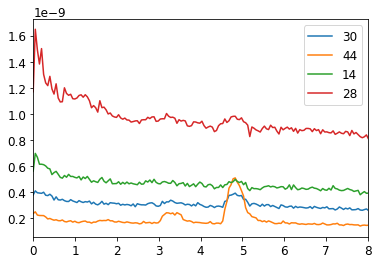

In [5]:
#solventstability DEMS expt


solventstabdems = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210623_Mg_solventstabilitytest_Ar_disch_dems/210623_Mg_solventstabilitytest_Ar_disch_dems_2021-06-23_15.00_49.txt')
solventstab_ec = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210623_Mg_solventstabilitytest_Ar_disch_dems/')


#plot_dems(solventstab_ec, solventstabdems, 1, n=1)


plt.figure()
i = 30
plt.plot(solventstabdems['time/min']/60, solventstabdems[str(i)], label = str(i))
plt.plot(solventstabdems['time/min']/60, solventstabdems[str(44)], label = str(44))
plt.plot(solventstabdems['time/min']/60, solventstabdems[str(14)], label = str(14))
plt.plot(solventstabdems['time/min']/60, solventstabdems[str(28)], label = str(28))
# plt.plot(solventstabdems['time/min']/60, solventstabdems[str(i+3)], label = str(i+3))
plt.xlim(0,8)
plt.legend()

80.61371 140.32707
0.0006997646189444047 0.00043942027713544593
0.04559485873908893 0.4719014779943183 0.5802566571524691


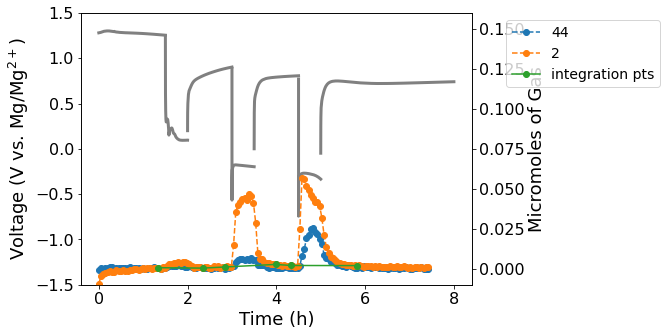

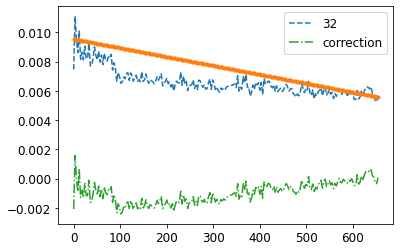

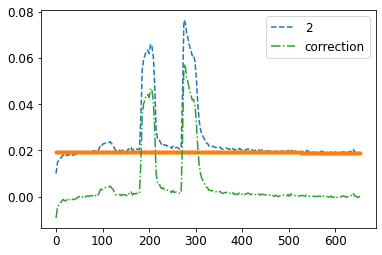

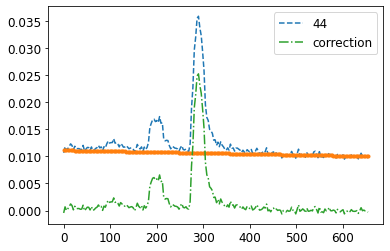

In [40]:
solventstabdems = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210623_Mg_solventstabilitytest_Ar_disch_dems/210623_Mg_solventstabilitytest_Ar_disch_dems_2021-06-23_15.00_49.txt')
solventstab_ec = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210623_Mg_solventstabilitytest_Ar_disch_dems/')


fig, ax= plt.subplots( figsize=(7,5))
ax2 = ax.twinx()

#ax2.plot(solventstability2p['time/s']/60/60,umoles, 'o', color = 'xkcd:dark grey', markersize= 2 )

solventstability_umoles = convert_ion_current(solventstabdems)
oxy1 = baselinecorr( solventstability_umoles, 32, 10, 500)
hydro1 = baselinecorr( oxy1, 2, 4000, 500)
co21 = baselinecorr( hydro1, 44, 10, 500)

solventstability_umoles=co21

currents = ['OCV','100 $\mu$A','', '500 $\mu$A','', '1 mA', '']
for i in range(len(solventstab_ec)):
    #if i%2 != 0:
    ax.plot(solventstab_ec[i]['time/s']/60/60, solventstab_ec[i]['Ewe/V'], label = str(currents[i]), linewidth = 3, color ='grey' )
    #else:
        #ax.plot(solventstab_ec[i]['time/s']/60/60, solventstab_ec[i]['Ewe/V'], label = str(currents[i]), color = 'grey', linewidth = 3 )


#         plt.plot(solventstability[i]['time/s'], solventstability[i]['Ewe/V'], color = 'teal')

gas_sums = np.cumsum(solventstability_umoles)
index1_start = getnearpos(solventstability_umoles['time/min'], 80)
index1_end = getnearpos(solventstability_umoles['time/min'], 140)
index2_start = getnearpos(solventstability_umoles['time/min'], 170)
index2_end = getnearpos(solventstability_umoles['time/min'], 240)
index3_start = getnearpos(solventstability_umoles['time/min'], 260)
index3_end = getnearpos(solventstability_umoles['time/min'], 350)



print(solventstability_umoles['time/min'].iloc[index1_start], solventstability_umoles['time/min'].iloc[index1_end])
print(solventstability_umoles['2'].iloc[index1_start], solventstability_umoles['2'].iloc[index1_end])

h2_1 = gas_sums['2'].iloc[index1_end] - gas_sums['2'].iloc[index1_start]
h2_2 = gas_sums['2'].iloc[index2_end] - gas_sums['2'].iloc[index2_start]
h2_3 = gas_sums['2'].iloc[index3_end] - gas_sums['2'].iloc[index3_start]

print(h2_1, h2_2, h2_3)
#ax2.plot(solventstability_umoles['time/min'][:150]/60, solventstability_umoles['32'][:150], 'o--', label ='32')
ax2.plot(solventstability_umoles['time/min'][:150]/60, solventstability_umoles['44'][:150], 'o--', label ='44')
ax2.plot(solventstability_umoles['time/min'][:150]/60, solventstability_umoles['2'][:150], 'o--', label = '2')

points_time = [ solventstability_umoles['time/min'].iloc[index1_start], solventstability_umoles['time/min'].iloc[index1_end], solventstability_umoles['time/min'].iloc[index2_start],solventstability_umoles['time/min'].iloc[index2_end],
              solventstability_umoles['time/min'].iloc[index3_start], solventstability_umoles['time/min'].iloc[index3_end]]
points_t_h =  [x / 60 for x in points_time]

points_h2 = [ solventstability_umoles['2'].iloc[index1_start], solventstability_umoles['2'].iloc[index1_end], solventstability_umoles['2'].iloc[index2_start],solventstability_umoles['2'].iloc[index2_end],
              solventstability_umoles['2'].iloc[index3_start], solventstability_umoles['2'].iloc[index3_end]]
ax2.plot(points_t_h, points_h2, 'o-', label = 'integration pts')
ax.set_ylim((-1.5,1.50))
ax2.set_ylim((-0.01,0.16))
ax2.set_ylabel('Micromoles of Gas', fontsize = 18)
ax.set_xlabel('Time (h)', fontsize = 18)
ax.set_ylabel('Voltage (V vs. Mg/Mg$^{2+}$)', fontsize = 18)
ax2.legend( bbox_to_anchor = (1.5,1), fontsize = 14)
ax.tick_params(axis='both', which='major', labelsize=16)
ax2.tick_params(axis='y', which='major', labelsize=16)
    
#fig.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210623_Mg_solventstabilitytest_Ar_disch_dems/210623_Mg_solventstability_dems.png', transparent = True, dpi=600, bbox_inches='tight')

